## Purpose

In this notebook, I extract the hidden state from BERT and train a logistic regression classifier on top.

This simple, lightweight approach can achieve an accuracy of 80%, higher than some BERT-related models.

### Step 1: Import Libraries

In [1]:
!pip install transformers

In [2]:
!pip install datasets

In [31]:
from transformers import AutoModel, AutoTokenizer
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from datasets import load_dataset

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

### Step 2: Utils Functions

In [32]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def forward_pass(batch):
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state.cpu().numpy()

    # Use average of unmasked hidden states for classification
    lhs_shape = last_hidden_state.shape
    boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
    boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
    boolean_mask = boolean_mask.reshape(lhs_shape)
    masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
    batch["hidden_state"] = masked_mean.data
    return batch

### Step 3: Load Data

In [36]:
model_name = 'bert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [33]:
data_path = '/content/drive/MyDrive/[P] DisasterTweets/data'
train = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [34]:
all_train_texts = train.text.to_list()
all_train_labels = train.target.to_list()

In [35]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_train_texts, all_train_labels, 
    test_size=0.2, 
    random_state=42
)

train_df = pd.DataFrame(list(zip(train_texts, train_labels)),
                        columns =['text', 'label'])

val_df = pd.DataFrame(list(zip(val_texts, val_labels)),
                      columns =['text', 'label'])

train_df.to_csv(os.path.join(data_path, 'train_df.csv'), index=False)
val_df.to_csv(os.path.join(data_path, 'val_df.csv'), index=False)

tweets_dataset_rand = load_dataset('csv', data_files={'train': os.path.join(data_path, 
                                                                            'train_df.csv'),
                                                      'validation': os.path.join(data_path, 
                                                                                'val_df.csv')})

tweets_encoded = tweets_dataset_rand.map(tokenize, batched=True, batch_size=None)

Using custom data configuration default-6cf71f85b822f173


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-6cf71f85b822f173/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


### Step 4: Extract Hidden State

In [37]:
tweets_encoded = tweets_encoded.map(forward_pass, batched=True,
                                     batch_size=16)

In [38]:
import numpy as np

X_train = np.array(tweets_encoded["train"]["hidden_state"])
X_valid = np.array(tweets_encoded["validation"]["hidden_state"])
y_train = np.array(tweets_encoded["train"]["label"])
y_valid = np.array(tweets_encoded["validation"]["label"])
X_train.shape, X_valid.shape

((6090, 768), (1523, 768))

### Step 4: Visualize Embeddings

In [14]:
!pip install umap-learn

In [39]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train

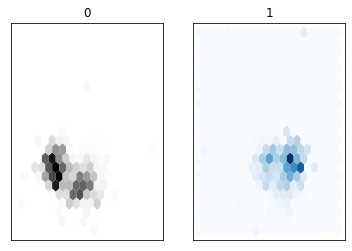

<Figure size 864x864 with 0 Axes>

In [40]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()
cmaps = ["Greys", "Blues"]
labels = ['0', '1']

plt.figure(figsize = (12, 12))
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

### Step 5: Apply Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(n_jobs=-1, penalty="none")
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Step 6: Evaluate

In [43]:
print(f'Accuracy: {lr_clf.score(X_valid, y_valid)}')

Accuracy: 0.8023637557452397


In [45]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f'Baseline Accuracy: {dummy_clf.score(X_valid, y_valid)}')

Baseline Accuracy: 0.5738673670387393


#### Confusion Matrix and Report

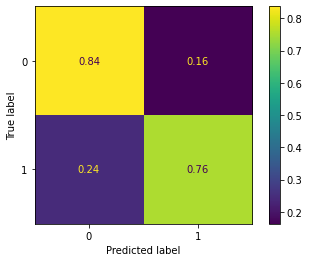

In [46]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(lr_clf, X_valid, y_valid, normalize='true')

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       874
           1       0.78      0.76      0.77       649

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523

